In [1]:
from scripts.imports import * 

/Users/leger/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/leger/Library/Python/3.9/lib/python/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/Users/leger/Library/Python/3.9/lib/python/site-pack

## CS-502 Deep Learning Project

Table of contents:
### 0) Processing Data, EDA presentation
### 1) CNN
### 2) ViT
### 2) Visualize Attention

In [2]:
train_info = pd.read_csv('train.csv')
test_info = pd.read_csv('test.csv')
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MAX_CLASSES = len(train_info.drop_duplicates('label')['label'].values.tolist())
print(train_info.drop_duplicates('label')['label'].values.tolist(), '\nmax_classes:', MAX_CLASSES, "device:", DEVICE)

['HGSC', 'LGSC', 'EC', 'CC', 'MC'] 
max_classes: 5 device: cpu


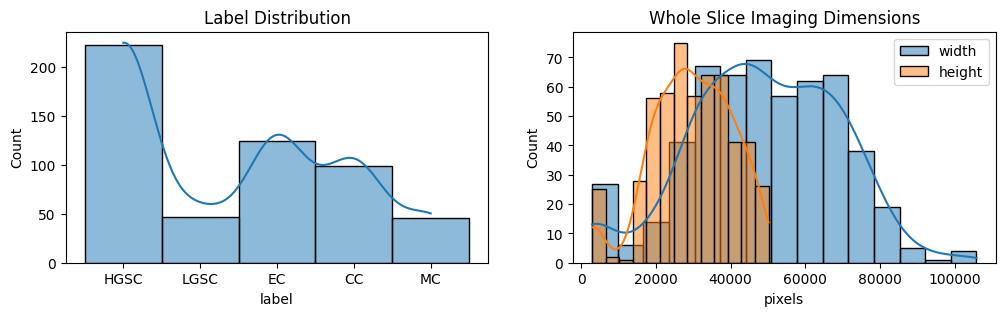

In [9]:
#Train label
fig, ax = plt.subplots(1, 2, figsize = (12, 3))
ax[0].set_title('Label Distribution')
sns.histplot(train_info['label'], kde =True, ax=ax[0])
sns.histplot(train_info['image_width'], kde = True, ax=ax[1], label = 'width', legend = 'True')
sns.histplot(train_info['image_height'], kde = True, ax=ax[1], label = 'height')
ax[1].legend(loc ='upper right')
ax[1].set_xlabel('pixels')
ax[1].set_title('Whole Slice Imaging Dimensions')
plt.show()

In [3]:
from scripts.imports import * 
from scripts.data_wrangling import *
from scripts.train import *
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
from torch.nn import functional as F

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def human_readable(num):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{:.2f}{}'.format(num, ['', 'K', 'M', 'B', 'T'][magnitude])

In [2]:
from scripts.model_configs import alexnet_config, reduced_alexnet_config, base_cnn_config


cnn_config = {
    # Preprocessing and augmentation configurations
    "preprocessing": resize,
    "augmentation": None,

    # Split ratio for train and validation datasets
    "train_size": 0.6,  # 80% for training, 20% for validation

    # Training parameters
    "batch_size": 5,
    "n_epochs": 10,
    "device": DEVICE,  # Using GPU if available

    # Model configuration
    "model_config": {**base_cnn_config
    },
    "model": "CNN",  # Or other models as per your setup

    # Optimizer configuration
    "optimizer": "AdamW",
    "learning_rate": 1e-3,

    # Loss function
    "loss_function": "CrossEntropy",  # or "BCELoss" or other as per your requirement

    # Scheduler configuration
    "scheduler": "CosineAnnealing",

    # Transforms (set to None as requested)
    "input_transform": identity,
    "labels_transform": one_hot_transform,
    "prediction_transform": identity
}

def number_of_params_cnn(model_config):
        
    # Calculate the number of parameters
    total_params = 0
    backbone_config = model_config['backbone']
    # Convolutional layers
    for in_channels, out_channels, (kernel_size, _, _), _, _ in backbone_config:
        total_params += (in_channels * kernel_size * kernel_size + 1) * out_channels

    classifier_config = model_config['classifier']
    # Fully connected layers
    for in_features, out_features, _, _ in classifier_config:
        total_params += (in_features + 1) * out_features

    return total_params

# Example
print("number of params alexnet:", human_readable(number_of_params_cnn(alexnet_config)))
print("number of params reduced alexnet:", human_readable(number_of_params_cnn(reduced_alexnet_config)))
print("number of params base cnn:", human_readable(number_of_params_cnn(base_cnn_config)))

print("Training Base CNN")
base_cnn, base_cnn_metrics = train_model(x_directory="train_thumbnails/", y_directory="train.csv", config=cnn_config)

number of params alexnet: 86.38M
number of params reduced alexnet: 21.93M
number of params base cnn: 2.65M
Training Base CNN
Dataloaders
Starting Epochs
Epoch: 001 train loss = 1.901158 val loss = 1.496056
Epoch: 002 train loss = 1.545775 val loss = 1.504018
Epoch: 003 train loss = 1.507680 val loss = 1.626694
Epoch: 004 train loss = 1.470981 val loss = 1.502306
Epoch: 005 train loss = 1.448749 val loss = 1.446897
Epoch: 006 train loss = 1.460560 val loss = 1.432035
Epoch: 007 train loss = 1.444596 val loss = 1.451855
Epoch: 008 train loss = 1.431910 val loss = 1.431804
Epoch: 009 train loss = 1.439383 val loss = 1.459340
Epoch: 010 train loss = 1.433737 val loss = 1.430142


In [6]:
from sklearn.metrics import accuracy_score
def compute_accuracy(model, x_directory, y_directory, subsample_fraction=None):
    model.eval()  # Set the model to evaluation mode
    dataset = CancerDataset(images_dir=x_directory, labels_dir=y_directory, preprocessing=resize)
    
    if subsample_fraction is not None:
        num_samples = int(len(dataset) * subsample_fraction)
        dataset = dataset[:num_samples]

    dataloader = DataLoader(dataset, batch_size=1) 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            data = torch.permute(data, (0, 3, 2, 1))
            labels = labels.to(device)

            # Forward pass to get predictions
            outputs = model(data)

            _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    return accuracy

compute_accuracy(model = base_cnn, x_directory="train_thumbnails/", y_directory="train.csv")

0.42300194931773877

Considering its a kaggle competition and its a baby alexnet, im kinda faker

In [4]:
from scripts.model_configs import vit_model_config, reduced_vit_config, base_vit_config

vit_config = {
    # Preprocessing and augmentation configurations
    "preprocessing": resize,
    "augmentation": None,

    # Split ratio for train and validation datasets
    "train_size": 0.6,  # 80% for training, 20% for validation

    # Training parameters
    "batch_size": 1,
    "n_epochs": 10,
    "device": DEVICE,  # Using GPU if available

    # Model configuration
    "model_config": {**base_vit_config
    },
    "model": "ViT",  # Or other models as per your setup

    # Optimizer configuration
    "optimizer": "AdamW",
    "learning_rate": 1e-3,

    # Loss function
    "loss_function": "CrossEntropy",  # or "BCELoss" or other as per your requirement

    # Scheduler configuration
    "scheduler": "CosineAnnealing",

    # Transforms (set to None as requested)
    "input_transform": identity,
    "labels_transform": one_hot_transform,
    "prediction_transform": identity
}
print("number of params ViT:", human_readable( count_parameters(model = ViT(config=vit_model_config))))
print("number of params reduced ViT:", human_readable(count_parameters(model = ViT(config=reduced_vit_config))))
print("number of params base ViT:", human_readable(count_parameters(model = ViT(config=base_vit_config))))

#base_vit, base_vit_metrics = train_model(x_directory="train_thumbnails/", y_directory="train.csv", config=vit_config)

number of params ViT: 87.15M
number of params reduced ViT: 35.18M
number of params base ViT: 4.93M


In [4]:
base_vit_small_config = {
    "image_size": (1000, 500),  # Image dimensions (width, height)
    "patch_size": 25,
    "in_channels": 3,
    "embedding_dims": 128*3, #384
    "num_transformer_layers": 2,
    "mlp_dropout": 0.1,
    "attn_dropout": 0.1,
    "mlp_size": 512,
    "num_heads": 6,
    "num_classes": 5,
    "batch_size": 1
}

print("number of params ViT:", human_readable( count_parameters(model = ViT(config=base_vit_small_config))))
vit_config['model_config'] = {**base_vit_small_config}
base_vit_small, base_vit_small_metrics = train_model(x_directory="train_thumbnails/", y_directory="train.csv", config=vit_config)

number of params ViT: 3.01M
Dataloaders
Starting Epochs
Epoch: 001 train loss = 1.813782 val loss = 1.541842
Epoch: 002 train loss = 1.574000 val loss = 1.445949
Epoch: 003 train loss = 1.505072 val loss = 1.513461
Epoch: 004 train loss = 1.475664 val loss = 1.412611
Epoch: 005 train loss = 1.467678 val loss = 1.433554
Epoch: 006 train loss = 1.461276 val loss = 1.393452
Epoch: 007 train loss = 1.448093 val loss = 1.427259
Epoch: 008 train loss = 1.434441 val loss = 1.403883
Epoch: 009 train loss = 1.422673 val loss = 1.407367
Epoch: 010 train loss = 1.403130 val loss = 1.408694


In [5]:
base_vit_small_config = {
    "image_size": (1000, 500),  # Image dimensions (width, height)
    "patch_size": 25,
    "in_channels": 3,
    "embedding_dims": 128*3, #384
    "num_transformer_layers": 2,
    "mlp_dropout": 0.1,
    "attn_dropout": 0.1,
    "mlp_size": 512,
    "num_heads": 6,
    "num_classes": 5,
    "batch_size": 1,
}
vit_config = {
    # Preprocessing and augmentation configurations
    "preprocessing": resize,
    "augmentation": None,

    # Split ratio for train and validation datasets
    "train_size": 0.6,  # 80% for training, 20% for validation

    # Training parameters
    "batch_size": 1,
    "n_epochs": 10,
    "device": DEVICE,  # Using GPU if available

    # Model configuration
    "model_config": {**base_vit_small_config
                     
    },
    "model": "ViT",  # Or other models as per your setup
    "attention": True,
    # Optimizer configuration
    "optimizer": "AdamW",
    "learning_rate": 1e-3,

    # Loss function
    "loss_function": "CrossEntropy",  # or "BCELoss" or other as per your requirement

    # Scheduler configuration
    "scheduler": "CosineAnnealing",

    # Transforms (set to None as requested)
    "input_transform": identity,
    "labels_transform": one_hot_transform,
    "prediction_transform": identity
}
print("number of params ViT:", human_readable( count_parameters(model = ViT(config=base_vit_small_config))))
vit_config['model_config'] = {**base_vit_small_config}
base_vit_small, base_vit_small_metrics, attention_weights = train_model(x_directory="train_thumbnails/", y_directory="train.csv", config=vit_config)

number of params ViT: 3.01M
['train_thumbnails/10077_thumbnail.png', 'train_thumbnails/10143_thumbnail.png', 'train_thumbnails/1020_thumbnail.png', 'train_thumbnails/10246_thumbnail.png', 'train_thumbnails/10252_thumbnail.png', 'train_thumbnails/10469_thumbnail.png', 'train_thumbnails/10548_thumbnail.png', 'train_thumbnails/10642_thumbnail.png', 'train_thumbnails/10800_thumbnail.png', 'train_thumbnails/1080_thumbnail.png', 'train_thumbnails/10896_thumbnail.png', 'train_thumbnails/1101_thumbnail.png', 'train_thumbnails/11263_thumbnail.png', 'train_thumbnails/11417_thumbnail.png', 'train_thumbnails/11431_thumbnail.png', 'train_thumbnails/11557_thumbnail.png', 'train_thumbnails/11559_thumbnail.png', 'train_thumbnails/12159_thumbnail.png', 'train_thumbnails/12222_thumbnail.png', 'train_thumbnails/12244_thumbnail.png', 'train_thumbnails/12442_thumbnail.png', 'train_thumbnails/12522_thumbnail.png', 'train_thumbnails/1252_thumbnail.png', 'train_thumbnails/1289_thumbnail.png', 'train_thumbnail

## ViT

## Visualizing Attention

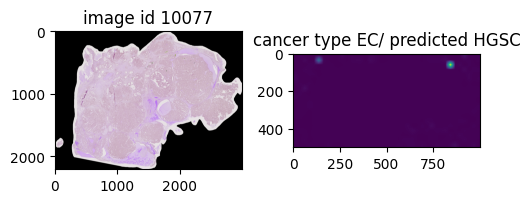

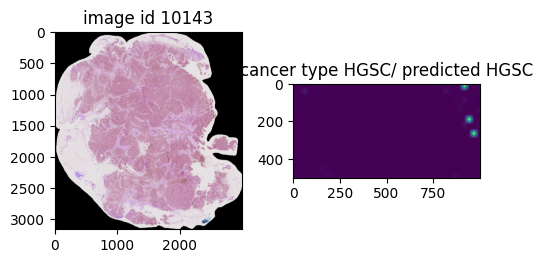

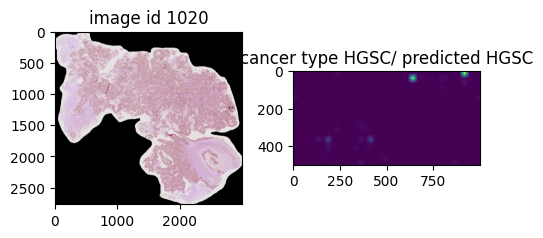

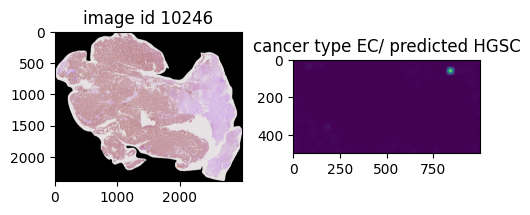

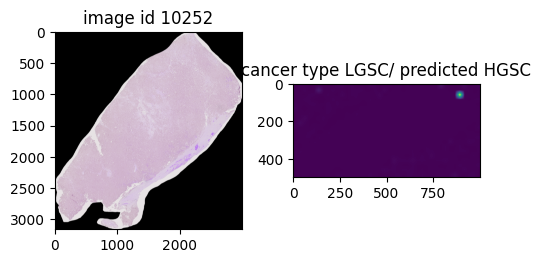

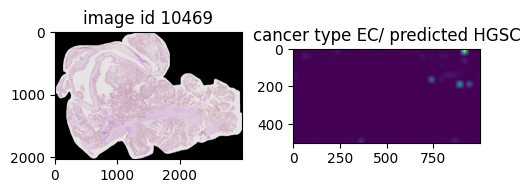

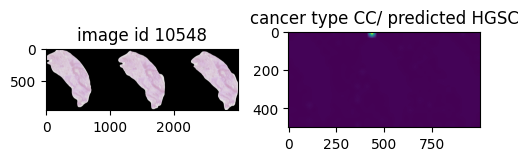

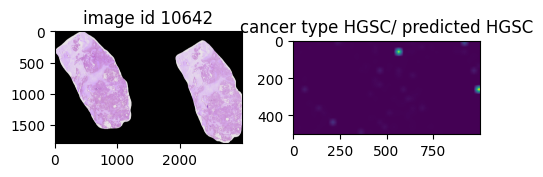

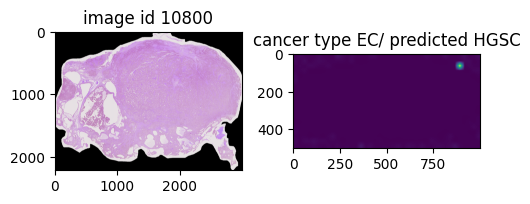

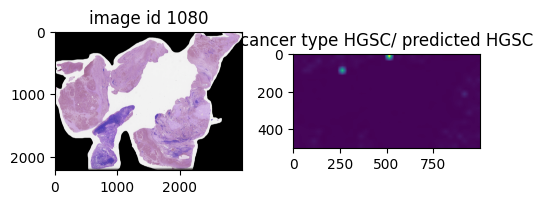

In [6]:
def visualize_attention(model, x_directory, y_directory, preprocessing, size=10):
    """
    Visualize the attention maps of the first 4 images.
    """
    model.eval()
    for root, dirs, files in sorted(os.walk(x_directory)): image_filenames = sorted(files)
    labels_df = pd.read_csv(y_directory)
    #one hot encoding
    one_hot_encoder = {}
    for k, v in enumerate(labels_df.drop_duplicates('label')['label'].values.tolist()): one_hot_encoder[v] = k

    patch_size = 25
    image_size = (1000, 500)
    num_of_patches = int((image_size[0] * image_size[1]) / patch_size**2)
    #print(num_of_patches)
    data = {"image_id": [], "images":[], "labels":[], "predictions": [], "maps": []}
    for filename in image_filenames[:10]:

        image = cv.imread(x_directory+filename).astype('float32')
        data['images'].append(cv.imread(x_directory+filename).astype('int'))
        #print(filename)
        image_id = int(re.search(r'\d+', filename).group())
        label = labels_df[labels_df['image_id'] == image_id]['label'].values.tolist()[0]
        label_id = one_hot_encoder[label]

        image = torch.permute(torch.tensor(preprocessing(image=image)[:, :, :, None], dtype=torch.float32), (3, 2, 1, 0))
        #print(image.shape)
        prediction, attention = model(image)
        #last layer of attention
        attention = attention[1]
        #cls token attention
        attention = attention[:, 0, 1:]
        #reshape patches to 2d
        patches_w, patches_h = (int(image_size[0]/patch_size), int(image_size[1]/patch_size))
        attention = attention.view(-1, patches_w, patches_h)
        attention = attention.unsqueeze(1)
        attention = F.interpolate(attention, size= (image_size[0], image_size[1]), mode= 'bilinear', align_corners=False)
        attention = attention.squeeze(1)

        prediction_id = torch.argmax(prediction, dim=1).detach().numpy()[0]
        prediction_label = None
        for key, value in one_hot_encoder.items():
            if prediction_id == value:
                prediction_label = key
        #print(label, prediction_label)
        #print(prediction.shape, attention.shape)
        data['image_id'].append(image_id)
        data['labels'].append(label)
        data['predictions'].append(prediction_label)
        data['maps'].append(attention)

    number = len(data['image_id'])
    for i in range(number):
        
        fig, ax = plt.subplots(1, 2, figsize= (5, 12))
        #print(len(torch.permute(data['images'][i][0], (2, 1, 0)))
        ax[0].imshow(data['images'][i])#torch.permute(data['images'][i][0], (2, 1, 0)).detach().numpy())
        ax[0].set_title(f"image id {data['image_id'][i]}")
        #print(data['images'][i].shape)
        attention_map = data['maps'][i].T.detach().numpy()
        ax[1].imshow(attention_map)#, cmap = 'jet')
        #print(min(np.unique(attention_map)), max(np.unique(attention_map)))
        ax[1].set_title(f"cancer type {data['labels'][i]}/ predicted {data['predictions'][i]}")
        plt.tight_layout()
        plt.show()

visualize_attention(model=base_vit_small, x_directory="train_thumbnails/", y_directory="train.csv", preprocessing=resize)

In [41]:
def number_of_params_vit(config):
    # Extracting values from the config
    image_width = config['image_size'][0]
    image_height = config['image_size'][1]
    patch_size = config['patch_size']
    in_channels = config['in_channels']
    embedding_dims = config['embedding_dims']
    num_transformer_layers = config['num_transformer_layers']
    mlp_size = config['mlp_size']
    num_heads = config['num_heads']
    num_classes = config['num_classes']

    # Calculating the number of patches
    num_patches = (image_width * image_height) // (patch_size ** 2)

    # Patch Embedding Layer Parameters
    patch_embedding_params = (patch_size ** 2 * in_channels + 1) * embedding_dims

    # Position Embedding Parameters
    position_embedding_params = (num_patches + 1) * embedding_dims

    # Transformer Block Parameters
    transformer_block_params = num_transformer_layers * (
        # Multi-Head Self-Attention (MSA) Parameters
        (3 * (embedding_dims ** 2) / num_heads) * num_heads +
        embedding_dims ** 2 +  # Output linear layer in MSA
        2 * embedding_dims +  # LayerNorm in MSA
        # MLP Block Parameters
        (embedding_dims * mlp_size + mlp_size * embedding_dims) +
        2 * embedding_dims  # LayerNorm in MLP
    )

    # Classifier Parameters
    classifier_params = embedding_dims * num_classes

    # Summing up all parameters
    total_params = (patch_embedding_params + position_embedding_params +
                    transformer_block_params + classifier_params)

    return total_params

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


'2.65M'